In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import random
from keras.losses import SparseCategoricalCrossentropy
from collections import Counter
import seaborn as sns


In [3]:
def fetch_image(data_folder):
    train_data = []
    test_data = []
    valid_data = []

    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }

    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")

        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)

            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue

            # Load and preprocess the image
            imgTrafficSignal = Image.open(image_path)
            imgTrafficSignal = imgTrafficSignal.convert("L")  # Convert to grayscale
            img_width, img_height = imgTrafficSignal.size

            with open(label_path, "r") as label_file:
                label_lines = label_file.readlines()
                for line in label_lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert normalized bounding box to pixel coordinates
                    x_center_pixel = int(x_center * img_width)
                    y_center_pixel = int(y_center * img_height)
                    width_pixel = int(width * img_width)
                    height_pixel = int(height * img_height)

                    # Calculate the bounding box corners
                    x1 = max(x_center_pixel - width_pixel // 2, 0)
                    y1 = max(y_center_pixel - height_pixel // 2, 0)
                    x2 = min(x_center_pixel + width_pixel // 2, img_width)
                    y2 = min(y_center_pixel + height_pixel // 2, img_height)

                    # Crop the sign area from the image
                    cropped_img = imgTrafficSignal.crop((x1, y1, x2, y2))
                    cropped_img = cropped_img.resize((90, 90))  # Resize to 90x90

                    # Append the cropped image and class ID to the appropriate dataset
                    if split_name == "train":
                        train_data.append((np.array(cropped_img), class_id))
                    elif split_name == "test":
                        test_data.append((np.array(cropped_img), class_id))
                    elif split_name == "valid":
                        valid_data.append((np.array(cropped_img), class_id))

    return train_data, test_data, valid_data

In [4]:
# Example usage
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image(data_folder)

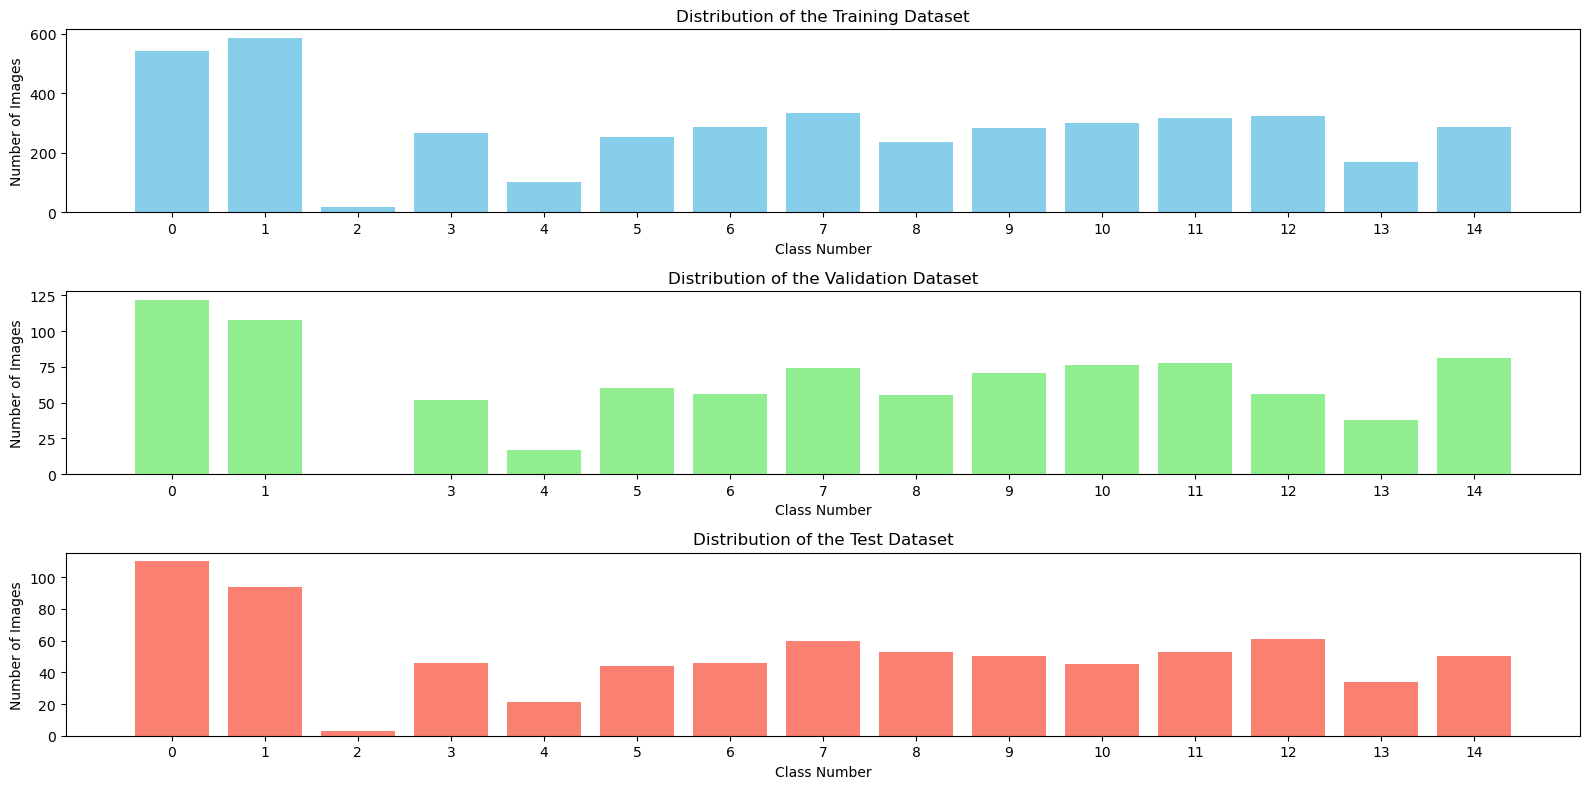

In [5]:
# Count the number of samples per class in each dataset
train_class_counts = Counter(class_id for _, class_id in train_data)
valid_class_counts = Counter(class_id for _, class_id in valid_data)
test_class_counts = Counter(class_id for _, class_id in test_data)

# Sort the counts for consistent visualization
train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

# Plot the distributions for all splits
plt.figure(figsize=(16, 8))

# Training Dataset
plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

# Validation Dataset
plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

# Test Dataset
plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

# Show the combined plot
plt.tight_layout()
plt.show()


In [6]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)

# Normalize the images
# Normalize the images to 0-1
training_data_features = training_data_features.astype(np.float32) / 255.0

# Reshape for CNN (add channel dimension)
training_data_features = training_data_features.reshape(-1, 90, 90, 1)

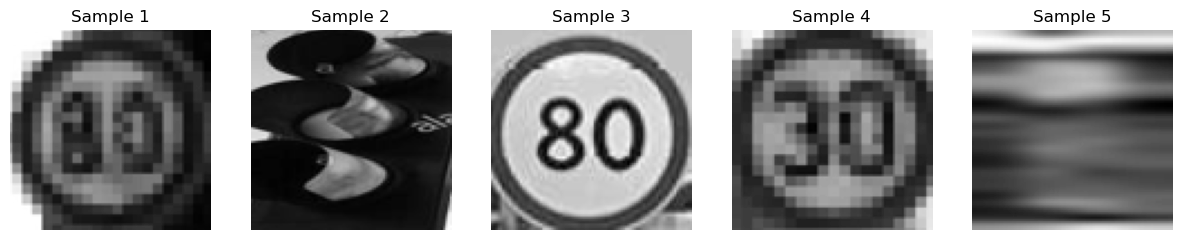

In [7]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    random_idx = random.randint(0, len(training_data_features) - 1)
    img = training_data_features[random_idx]

    # Ensure proper scaling to 0-255
    img = (img * 255).astype(np.uint8)

    axs[i].imshow(img, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Sample {i+1}")

plt.show()


In [8]:
training_data_labels

array([ 7,  7,  7, ..., 14, 14, 14])

In [9]:
cnnModel = Sequential()

# Convolutional Block 1
cnnModel.add(Conv2D(16, (3,3), padding="same", input_shape=(90, 90, 1), activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.2))  # Dropout after the first pooling layer

# Convolutional Block 2
cnnModel.add(Conv2D(32, (3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.2))  # Dropout after the second pooling layer

# Convolutional Block 3
cnnModel.add(Conv2D(64, (5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.3))  # Dropout after third pooling layer

# Convolutional Block 4
cnnModel.add(Conv2D(128, (7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.3))  # Dropout after the fourth pooling layer

# Fully Connected (Dense) Layers
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dropout(0.5))  # Dropout after Dense layer to reduce overfitting
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dropout(0.5))  # Dropout after second Dense layer
cnnModel.add(Dense(15, activation='softmax'))

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
cnnModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 90, 90, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 232)            │     1,069,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 232)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 116)            │        27,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 116)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,555,671 (5.93 MB)

 Trainable params: 1,555,671 (5.93 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.optimizers import Adam

cnnModel.compile(optimizer=Adam(learning_rate=0.0001), 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training if no improvement for 3 consecutive epochs
    restore_best_weights=True  # Restore the best model weights after stopping
)
# Define the ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=2,          # After 2 epochs of no improvement
    min_lr=1e-6          # Set a lower bound for the learning rate
)


In [13]:
# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)

# Normalize validation images
validation_data_features = validation_data_features / 255.0
validation_data_features = validation_data_features.reshape(-1, 90, 90, 1)

# Train the model
trafficSignNetwork = cnnModel.fit(
    training_data_features, 
    training_data_labels, 
    validation_data=(validation_data_features, validation_data_labels),
    epochs=40, 
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]  # Include the callbacks
)

Epoch 1/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.0995 - loss: 2.6810 - val_accuracy: 0.1790 - val_loss: 2.6601 - learning_rate: 1.0000e-04
Epoch 2/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1398 - loss: 2.6248 - val_accuracy: 0.2256 - val_loss: 2.5752 - learning_rate: 1.0000e-04
Epoch 3/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1997 - loss: 2.5163 - val_accuracy: 0.3432 - val_loss: 2.2990 - learning_rate: 1.0000e-04
Epoch 4/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2782 - loss: 2.2559 - val_accuracy: 0.3496 - val_loss: 2.0168 - learning_rate: 1.0000e-04
Epoch 5/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.3198 - loss: 2.0890 - val_accuracy: 0.4025 - val_loss: 1.9088 - learning_rate: 1.0000e-04
Epoch 6/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.3438 - loss: 1.9850 - val_accuracy: 0.4258 - val_loss: 1.8400 - learning_rate: 1.0000e-04
Epoch 7/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - 

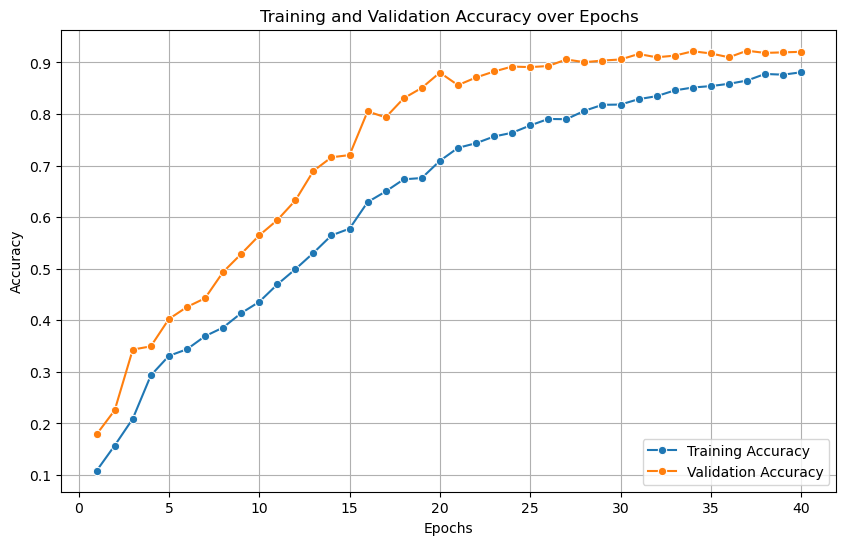

In [14]:
import seaborn as sns
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['accuracy']) + 1)),
             y=trafficSignNetwork.history['accuracy'],
             marker='o', label='Training Accuracy')

sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['val_accuracy']) + 1)),
             y=trafficSignNetwork.history['val_accuracy'],
             marker='o', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

In [15]:
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features)
test_data_labels = np.array(test_data_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


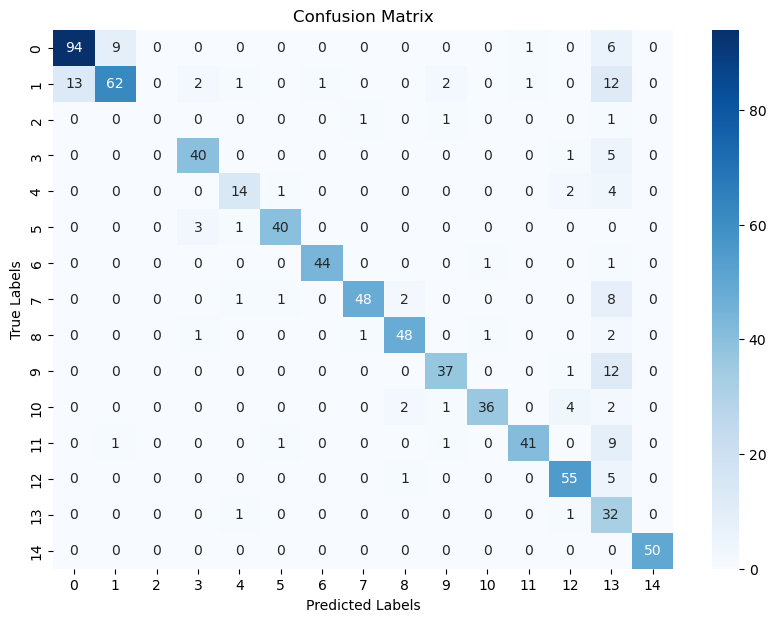

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [17]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       110
           1       0.86      0.66      0.75        94
           2       0.00      0.00      0.00         3
           3       0.87      0.87      0.87        46
           4       0.78      0.67      0.72        21
           5       0.93      0.91      0.92        44
           6       0.98      0.96      0.97        46
           7       0.96      0.80      0.87        60
           8       0.91      0.91      0.91        53
           9       0.88      0.74      0.80        50
          10       0.95      0.80      0.87        45
          11       0.95      0.77      0.85        53
          12       0.86      0.90      0.88        61
          13       0.32      0.94      0.48        34
          14       1.00      1.00      1.00        50

    accuracy                           0.83       770
   macro avg       0.81      0.79      0.78       770
weighted avg       0.88   

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 94
False Positive (FP): 13
False Negative (FN): 16
True Negative (TN): 647
Precision: 0.8785
Recall: 0.8545
F1-Score: 0.8664
Accuracy: 0.9623

Class 1:
True Positive (TP): 62
False Positive (FP): 10
False Negative (FN): 32
True Negative (TN): 666
Precision: 0.8611
Recall: 0.6596
F1-Score: 0.7470
Accuracy: 0.9455

Class 2:
True Positive (TP): 0
False Positive (FP): 0
False Negative (FN): 3
True Negative (TN): 767
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Accuracy: 0.9961

Class 3:
True Positive (TP): 40
False Positive (FP): 6
False Negative (FN): 6
True Negative (TN): 718
Precision: 0.8696
Recall: 0.8696
F1-Score: 0.8696
Accuracy: 0.9844

Class 4:
True Positive (TP): 14
False Positive (FP): 4
False Negative (FN): 7
True Negative (TN): 745
Precision: 0.7778
Recall: 0.6667
F1-Score: 0.7179
Accuracy: 0.9857

Class 5:
True Positive (TP): 40
False Positive (FP): 3
False Negative (FN): 4
True Negative (TN): 723
Precision: 0.9302
Recall: 0.9091
F1-Score: 0.

In [36]:
cnnModel.save("modelb.h5")
